In [1]:
import pandas as pd 
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

# Embed the Relationships and Entities

In [2]:
input_file = 'datasets/kinship.data'
output_file = 'datasets/kinship.txt'

with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        # Skip empty lines
        if not line.strip():
            continue
        
        # Example: father(Christopher, Victoria)
        # Extract relation, subject, and object from the line
        relation, rest = line.split('(')
        rest = rest.strip(')\n')
        subject, obj = rest.split(', ')
        
        # Write in triplet format: subject relation object
        outfile.write(f"{subject} {relation} {obj}\n")

In [3]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import numpy as np
from sklearn.model_selection import train_test_split

# Path to your dataset
triples_path = 'datasets/kinship.txt'

# Manually load the triples from the file
triples = []
with open(triples_path, 'r') as file:
    for line in file:
        columns = line.strip().split()
        if len(columns) == 3:
            triples.append(columns)

# Convert to numpy array (what PyKEEN expects)
triples_array = np.array(triples)

# Split data into training and testing
train_triples, test_triples = train_test_split(triples_array, test_size=0.2, random_state=42)
train_triples, valid_triples = train_test_split(train_triples, test_size=0.2, random_state=42)

# Create TriplesFactory instances
train_factory = TriplesFactory.from_labeled_triples(train_triples)
test_factory = TriplesFactory.from_labeled_triples(test_triples)
valid_factory = TriplesFactory.from_labeled_triples(valid_triples)

# Run the pipeline
result = pipeline(
    training=train_factory,
    testing=test_factory,
    validation=valid_factory,
    model='TransE',
    training_loop='lcwa',  # Keep 'lcwa'
    optimizer='Adam',
    loss='MarginRankingLoss',
    training_kwargs=dict(num_epochs=50, batch_size=128),
    model_kwargs=dict(embedding_dim=200)
)

No random seed is specified. Setting to 612222767.
No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 50/50 [00:07<00:00,  6.69epoch/s, loss=0.178, prev_loss=0.181]
Evaluating on cpu:   0%|          | 0.00/23.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 23.0/23.0 [00:00<00:00, 719triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [4]:
result.save_to_directory('kinship_embeddings')

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=24, num_relations=12, create_inverse_triples=False, num_triples=71) to file:///Users/emrekuru/Developer/LTN_Imp/examples/kinship/kinship_embeddings/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/emrekuru/Developer/LTN_Imp/examples/kinship/kinship_embeddings


0.3695652173913043

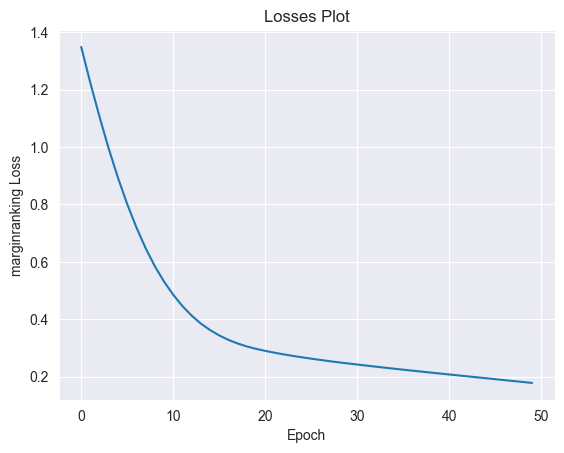

In [5]:
result.plot_losses()
result.get_metric('hits_at_k')

# Prepare Datasets

In [6]:
def prepare_classification_dataset(result, kinship_file):
    # Extract entity embeddings using PyKEEN's callable API
    entity_embeddings = result.model.entity_representations[0]()  # Access the embeddings as a tensor
    entity_embeddings_array = entity_embeddings.detach().cpu().numpy()  # Convert to NumPy array
    
    # Get the entity-to-ID mapping
    entity_to_id = result.training.entity_to_id
    
    # Create a dictionary mapping entity names to embeddings
    entity_embedding_dict = {entity: entity_embeddings_array[idx] for entity, idx in entity_to_id.items()}
    
    # Prepare lists to store the subject embedding, object embedding, and relationship labels
    subject_embeddings = []
    object_embeddings = []
    relationship_labels = []
    
    # Read the kinship file and generate rows of (subject embedding, object embedding, relationship label)
    with open(kinship_file, 'r') as file:
        for line in file:
            subject, relation, object_ = line.strip().split()

            # Get the embeddings for subject and object
            if subject in entity_embedding_dict and object_ in entity_embedding_dict:
                subject_embedding = entity_embedding_dict[subject]
                object_embedding = entity_embedding_dict[object_]
                
                # Append to the respective lists
                subject_embeddings.append(subject_embedding)
                object_embeddings.append(object_embedding)
                relationship_labels.append(relation)  # You can encode this as integers later if needed

    # Convert lists to NumPy arrays
    X_subjects = np.array(subject_embeddings)
    X_objects = np.array(object_embeddings)
    y_labels = np.array(relationship_labels)
    
    # Concatenate subject and object embeddings to form the feature matrix
    X = np.hstack((X_subjects, X_objects))
    return X, y_labels

def prepare_datasets(data, test_size = 0.3, random_state = 42):
    X_train, X_test = train_test_split(data, test_size=test_size, random_state=random_state)
    X_train.to_csv('datasets/train.csv', index=False)
    X_test.to_csv('datasets/test.csv', index=False)
    return X_train, X_test

In [7]:
X, Y = prepare_classification_dataset(result, 'datasets/kinship.txt')
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.fit_transform(Y)
data = pd.concat([pd.DataFrame(X), pd.Series(Y, name="Target")], axis=1)
X_train, X_test = prepare_datasets(data)

# EDA

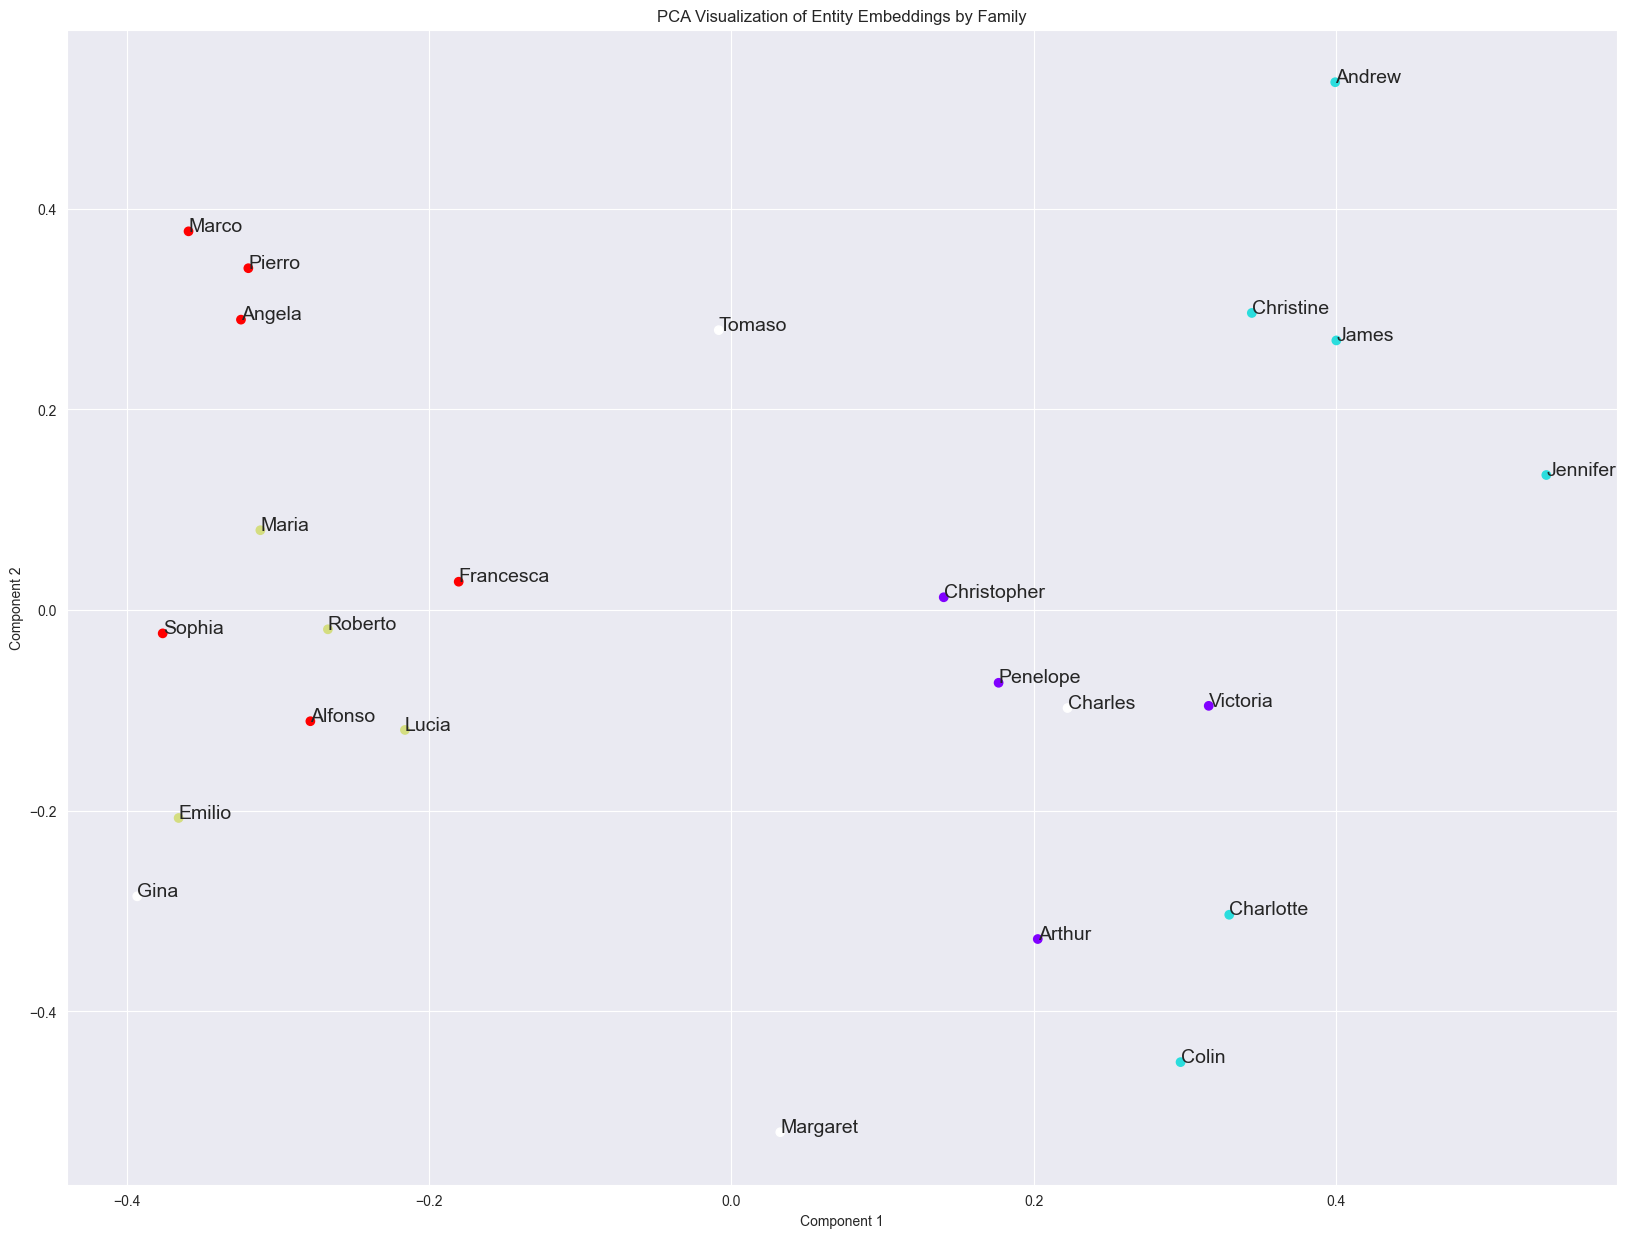

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import cm

def assign_family(family_groups, subject, object_, relation, parent_colors):
    """
    Assign subject and object to the same family group only if the relation is parent-child.
    Parents retain the same color across nuclear families.
    """
    parent_child_relations = ['father', 'mother', 'son', 'daughter']
    
    # Check if the relation is relevant (parent-child)
    if relation not in parent_child_relations:
        return family_groups, parent_colors  # Ignore non-parent-child relations
    
    # Ensure both subject and object (parent-child) are assigned the same family
    for family, members in family_groups.items():
        if subject in members or object_ in members:
            # Add both to the same family
            family_groups[family].add(subject)
            family_groups[family].add(object_)
            
            # Ensure parents retain the same color across families
            if relation in ['father', 'mother']:  # Subject is a parent
                if subject not in parent_colors:
                    parent_colors[subject] = parent_colors.get(object_, None)
                if object_ not in parent_colors:
                    parent_colors[object_] = parent_colors.get(subject, None)
            return family_groups, parent_colors

    # If neither is in an existing family, create a new family
    new_family = f"Family_of_{subject}_{object_}"
    family_groups[new_family] = {subject, object_}
    return family_groups, parent_colors

def visualize_embeddings_by_family(result, kinship_file, method='pca', n_components=2):
    entity_embeddings = result.model.entity_representations[0]()  # Get embeddings
    entity_embeddings_array = entity_embeddings.detach().cpu().numpy()  # Convert to NumPy array
    
    entity_to_id = result.training.entity_to_id
    entity_list = [entity for entity, idx in entity_to_id.items()]
    
    family_groups = {}
    parent_colors = {}  # Dictionary to store colors for parents across families
    
    # Process kinship relationships
    with open(kinship_file, 'r') as file:
        for line in file:
            subject, relation, object_ = line.strip().split()
            if relation in ['father', 'mother', 'son', 'daughter']:
                family_groups, parent_colors = assign_family(family_groups, subject, object_, relation, parent_colors)
    
    # Assign unique colors to families and ensure parents keep the same color
    unique_families = list(family_groups.keys())
    colors_map = cm.rainbow(np.linspace(0, 1, len(unique_families)))  # Generate distinct colors
    family_colors = {family: colors_map[i] for i, family in enumerate(unique_families)}
    
    # Assign default colors to all entities
    colors = ['white'] * len(entity_list)  # Default color for non-family entities
    
    # Assign colors to family members
    for family, members in family_groups.items():
        family_color = family_colors[family]  # Get the unique color for this family
        for member in members:
            if member in entity_to_id:
                member_idx = entity_to_id[member]
                
                # Check if the member is a parent and already has a color assigned
                if member in parent_colors and parent_colors[member] is not None:
                    colors[member_idx] = parent_colors[member]
                else:
                    colors[member_idx] = family_color
                    if member in ['father', 'mother']:  # Save this color for the parent
                        parent_colors[member] = family_color
    
    # Ensure all colors are valid
    for i, color in enumerate(colors):
        if color is None:
            colors[i] = 'blue'  # Assign a default color if any color is missing
    
    # Apply PCA or other dimensionality reduction method
    reducer = PCA(n_components=n_components)
    reduced_embeddings = reducer.fit_transform(entity_embeddings_array)
    
    # Plot the embeddings with family colors
    fig = plt.figure(figsize=(20, 15))
    
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=1)
    plt.title('PCA Visualization of Entity Embeddings by Family')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    for i, entity in enumerate(entity_list):
        plt.annotate(entity, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=14, alpha=1)

    plt.show()

# Example usage:
visualize_embeddings_by_family(result, kinship_file='datasets/kinship.txt', method='pca', n_components=2)


# Optimize And Evaluate